# Introduction


## Problem statement


Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset. The objective is to <font size="4">**derive actionable insights from this data to enhance the customer experience**</font>. The challenge is to dissect the dataset to <font size="4">**uncover the critical touchpoints that contribute to customer drop-off and identify opportunities to streamline the application process and personalize communication**</font>. The ultimate goal is to <font size="4">**predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position**</font>.


## Selected variables


<strong><h5>1. General Client Information</h5></strong>

1. `clntnum`
2. `ctrycode_desc`
3. `stat_flag`
4. `min_occ_date`
5. `cltdob_fix`
6. `cltsex_fix`
7. `cltage` (Age of client)
8. `clt_ten` (Customer tenure)

<strong><h5>2. Client Risk and Status Indicators</h5></strong>

1. `flg_substandard`
2. `flg_is_borderline_standard`
3. `flg_is_revised_term`
4. `flg_has_health_claim`
5. `flg_gi_claim`
6. `flg_is_proposal`

<strong><h5>3. Demographic and Household Information</h5></strong>

1. `is_dependent_in_at_least_1_policy`
2. `annual_income_est`

<strong><h5>4. Policy and claim history</h5></strong>

1. `tot_inforce_pols`, `tot_cancel_pols`
2. `f_ever_declined_la`

<strong><h5>5. Target Column</h5></strong>

1. `f_purchase_lh` (Indicates if customer will purchase insurance in the next 3 months)


# Code


## Data cleaning


In [402]:
# %pip install pyarrow
# %pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from statsmodels.graphics.mosaicplot import mosaic
import pyarrow
import os
from datetime import datetime
currWD = os.getcwd()
print("Current Working Directory:", currWD)
# os.chdir("Set WD here")
filepath = "./data/catB_train.parquet"
data = pd.read_parquet(filepath, engine='pyarrow')

Current Working Directory: /Users/swislar/Desktop


In [403]:
# Adding cltage and clt_ten cols
# Drop rows with incomplete data for `cltdob_fix`
data['cltdob_fix'] = data['cltdob_fix'].replace("None", pd.NaT)
cltdob_rows = data[data['cltdob_fix'].isna()]
data = data.dropna(subset=['cltdob_fix'])
# Drop rows with incomplete data for `min_occ_date`
data['min_occ_date'] = data['min_occ_date'].replace("None", pd.NaT)
occDate_rows = data[data['min_occ_date'].isna()]
data = data.dropna(subset=['min_occ_date'])

# Convert cltdob_fix to datetime format and compute the client's age
currentDate = datetime.now()
data["cltdob_fix"] = data["cltdob_fix"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage"] = data["cltdob_fix"].map(
    lambda x: ((currentDate - x).days/365.25))
# Convert min_occ_date to datetime format and compute cltage_start
data["min_occ_date"] = data["min_occ_date"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage_start"] = (
    (data["min_occ_date"] - data["cltdob_fix"]).dt.days/365.25).round().astype(int)

# Computing the customer tenure
data["clt_ten"] = data["cltage"] - data["cltage_start"]
# Adding back NA rows
data = pd.concat([data, cltdob_rows, occDate_rows], axis=0)
# Coverting NA to 0 for "f_purchase_lh" col
data["f_purchase_lh"] = np.where(data["f_purchase_lh"].isna(), 0, 1)
# Coverting NA to 0 for "is_dependent_in_at_least_1_policy" col
data["is_dependent_in_at_least_1_policy"] = np.where(
    data["is_dependent_in_at_least_1_policy"].isna(), 0, 1)
# Filtering columns
columnNames = ["clntnum", "ctrycode_desc", "stat_flag", "min_occ_date", "cltdob_fix", "cltsex_fix", "cltage", "clt_ten",
               "flg_substandard", "flg_is_borderline_standard", "flg_is_revised_term", "flg_has_health_claim", "flg_gi_claim", "flg_is_proposal",
               "is_dependent_in_at_least_1_policy", "annual_income_est", "tot_inforce_pols", "tot_cancel_pols", "f_ever_declined_la",
               "f_purchase_lh"]
data = data.loc[:, columnNames]

## Data Analysis


In [404]:
# Filtering for the identified columns
colNames_set_1 = ["flg_has_health_claim", "flg_gi_claim", "is_dependent_in_at_least_1_policy",
                  "tot_inforce_pols", "annual_income_est", "f_purchase_lh", "tot_cancel_pols", "cltage", "clt_ten",
                  "flg_is_proposal"]
data_set_1 = data.loc[:, colNames_set_1]

# Perform imputation for missing data
label_encoder = LabelEncoder()
data_set_1['annual_income_est'] = label_encoder.fit_transform(
    data_set_1['annual_income_est'])
imputer = KNNImputer(n_neighbors=50)
imputed_data_set_1 = imputer.fit_transform(data_set_1)
data_set_1 = pd.DataFrame(imputed_data_set_1, columns=data_set_1.columns)

In [405]:
itemDict = {}

for category, encoded_value in zip(data['annual_income_est'], data_set_1['annual_income_est']):
    newItem = f"{encoded_value} {category}"
    if newItem not in itemDict:
        itemDict[newItem] = 0

print("Levels:")
for x in sorted(list(itemDict)):
    print(x)

Levels:
0.0 A.ABOVE200K
1.0 B.100K-200K
2.0 C.60K-100K
3.0 D.30K-60K
4.0 E.BELOW30K
5.0 None


In [406]:
# Clean up data from imputer
data_set_1["flg_has_health_claim"] = np.where(
    data_set_1["flg_has_health_claim"] < 0.5, 0, 1)

data_set_1["flg_gi_claim"] = np.where(
    data_set_1["flg_gi_claim"] < 0.5, 0, 1)

data_set_1["flg_is_proposal"] = np.where(
    data_set_1["flg_is_proposal"] < 0.5, 0, 1)

data_set_1["tot_inforce_pols"] = data_set_1["tot_inforce_pols"].astype(int)

data_set_1["is_dependent_in_at_least_1_policy"] = np.where(
    data_set_1["is_dependent_in_at_least_1_policy"] < 0.5, 0, 1)

data_set_1["annual_income_est"] = pd.Categorical(
    data_set_1["annual_income_est"].map({
        0: "Above 200K",
        1: "100K-200K",
        2: "60K-100K",
        3: "30K-60K",
        4: "Below 30K",
    })
).set_categories(["Below 30K", "30K-60K", "60K-100K", "100K-200K", "Above 200K"], ordered=True)

data_set_1["f_purchase_lh"] = np.where(
    data_set_1["f_purchase_lh"] < 0.5, 0, 1)

data_set_1["tot_cancel_pols"] = data_set_1["tot_cancel_pols"].astype(int)

data_set_1["cltage"] = data_set_1["cltage"].astype(int)

data_set_1["clt_ten"] = data_set_1["clt_ten"].astype(int)

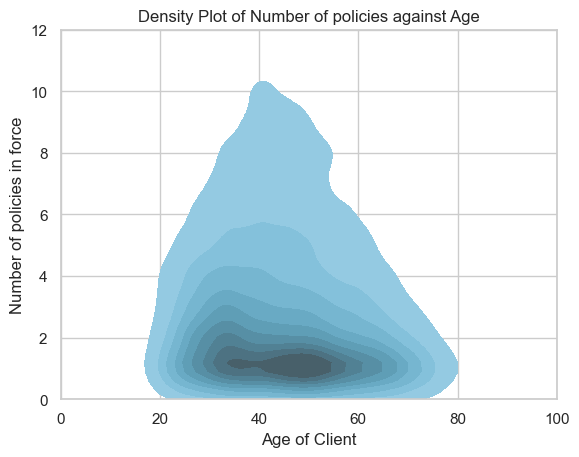

In [407]:
# Density Plot of Number of policies against Age
sns.set(style="whitegrid")
sns.kdeplot(x=data_set_1["cltage"],
            y=data_set_1["tot_inforce_pols"], fill=True, color="skyblue")
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.xlabel("Age of Client")
plt.ylabel("Number of policies in force")
plt.title("Density Plot of Number of policies against Age")
plt.show()

From the density plot, we can observe that a large concentration of clients belong to the 40-60 years old age group and they mostly have only 1 policy in force


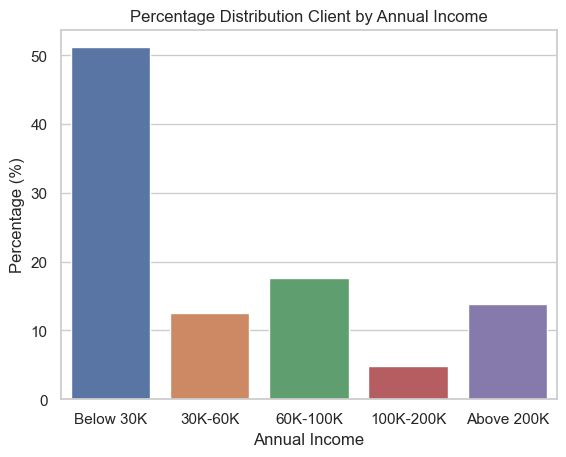

In [408]:
# Bar plot of Client count based on income
percentageIncome = data_set_1['annual_income_est'].value_counts(
    normalize=True) * 100

sns.barplot(x=percentageIncome.index, y=percentageIncome.values)

plt.xlabel('Annual Income')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution Client by Annual Income')
plt.show()

As we can see from the bar plot, A large majority of clients also belong to the Below 30K income group. Therefore, it might be easier to target and persuade clients from this income group who are between 40 to 60 years old to sign up for a policy.


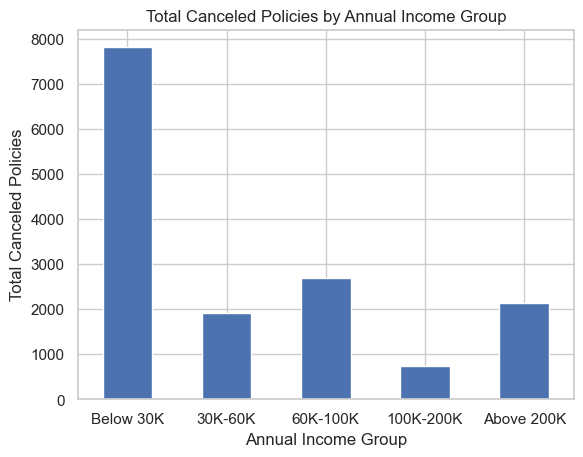

In [409]:
sum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

# Plot the result as a bar plot
sum_by_income_group.plot(kind='bar')

# Customize plot labels and title
plt.xlabel('Annual Income Group')
plt.ylabel('Total Canceled Policies')
plt.title('Total Canceled Policies by Annual Income Group')
plt.xticks(rotation=0)

plt.show()

Although a large number of clients belong to the Below 30K annual income group, they also have the highest cancellation count. To investigate further, we can visualise the cancellation rate for each income group.


In [410]:
# Rate of Policy Cancellation by Income Group
cilentCountByIncome = data_set_1['annual_income_est'].value_counts()
cancellationSum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

cancellation_rate_by_income = (
    cancellationSum_by_income_group / cilentCountByIncome)

print(cancellation_rate_by_income)

Below 30K     1.005919
30K-60K       1.006279
60K-100K      1.008585
100K-200K     1.011034
Above 200K    1.020982
dtype: float64


As seen from the table, the cancellation rate between all income groups are seen to be approximately the same. This means that it would be better to find clients that belong to the Under 30K income group, and are between 40 to 60 years old as they are more likely to sign up for the policy according to historical data.

To further support this relationship, we can plot a density plot and find out the ages of clients who are more likely to cancel their policy as the sign ups by clients aged 40 to 60 years old might also be the ones who cancel their policy.


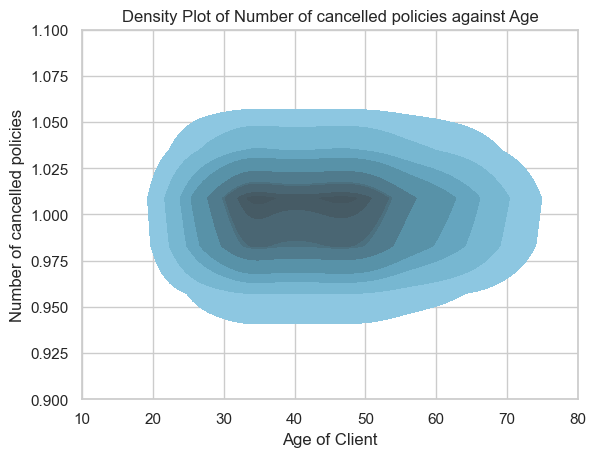

In [411]:
# Density Plot of Number of policies against Age
sns.set(style="whitegrid")
sns.kdeplot(x=data_set_1["cltage"],
            y=data_set_1["tot_cancel_pols"], fill=True, color="skyblue")
plt.xlim(10, 80)
plt.ylim(0.9, 1.1)
plt.xlabel("Age of Client")
plt.ylabel("Number of cancelled policies")
plt.title("Density Plot of Number of cancelled policies against Age")
plt.show()

From this density plot, we can see that clients who are more likely to cancel their policy are between 32 to 50. Since we have found that those between 40 to 60 years old are most likely to sign up, from our new findings, we can further narrow down this age group to 50 to 60 years old. As the client ages, we can also see that they would be more unlikely to cancel their policy, allowing the company to retain more clients in the long run.

Therefore, it would be better to find clients that belong to the Under 30K income group, and are between 50 to 60 years old as they are more likely to sign up for the policy without cancelling it.


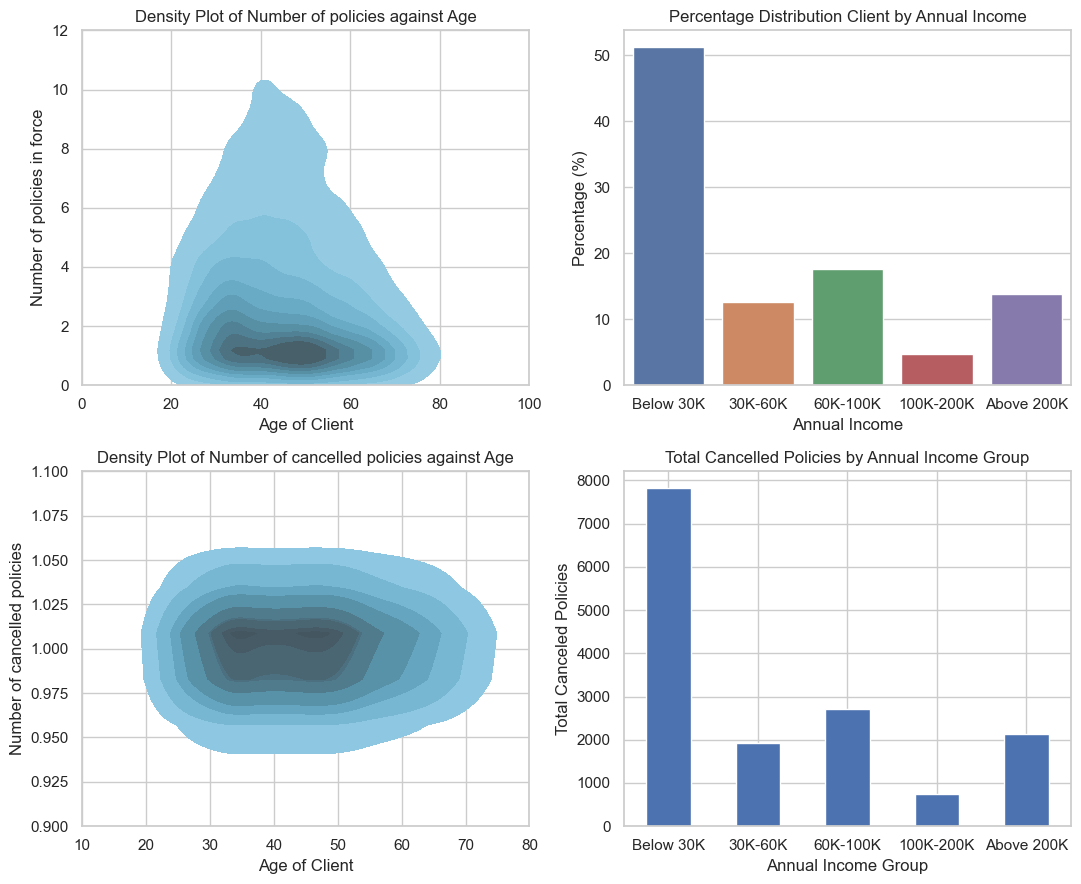

In [450]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Density Plot of Number of policies against Age
sns.kdeplot(x=data_set_1["cltage"], y=data_set_1["tot_inforce_pols"],
            fill=True, color="skyblue", ax=axes[0, 0])
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_ylim(0, 12)
axes[0, 0].set_xlabel("Age of Client")
axes[0, 0].set_ylabel("Number of policies in force")
axes[0, 0].set_title("Density Plot of Number of policies against Age")

# Bar plot of Client count based on income
percentageIncome = data_set_1['annual_income_est'].value_counts(
    normalize=True) * 100
sns.barplot(x=percentageIncome.index, y=percentageIncome.values, ax=axes[0, 1])
axes[0, 1].set_xlabel('Annual Income')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_title('Percentage Distribution Client by Annual Income')

# Density Plot of Number of Total Cancelled policies against Age
sns.kdeplot(x=data_set_1["cltage"], y=data_set_1["tot_cancel_pols"],
            fill=True, color="skyblue", ax=axes[1, 0])
axes[1, 0].set_xlim(10, 80)
axes[1, 0].set_ylim(0.9, 1.1)
axes[1, 0].set_xlabel("Age of Client")
axes[1, 0].set_ylabel("Number of cancelled policies")
axes[1, 0].set_title(
    "Density Plot of Number of cancelled policies against Age")

# Bar plot of Total Cancelled Policies by Annual Income Group
sum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()
sum_by_income_group.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Annual Income Group')
axes[1, 1].set_ylabel('Total Canceled Policies')
axes[1, 1].set_title('Total Cancelled Policies by Annual Income Group')
axes[1, 1].tick_params(rotation=0)

plt.tight_layout()
plt.show()

In [412]:
print("Has proposal:")
print(data_set_1["flg_is_proposal"].value_counts(normalize=True))
print("\nIs purchasing:")
print(data_set_1["f_purchase_lh"].value_counts(normalize=True))

Has proposal:
0    0.997277
1    0.002723
Name: flg_is_proposal, dtype: float64

Is purchasing:
0    0.960538
1    0.039462
Name: f_purchase_lh, dtype: float64


In [413]:
# Splitting the clients up based on those that is going to purchase a policy and those undecided
satisfiedClients = data_set_1[data_set_1["f_purchase_lh"] == 1]
moodClients = data_set_1[data_set_1["f_purchase_lh"] != 1]
# Selecting potentially useful variables for analysis
satisfiedClients = satisfiedClients[["tot_inforce_pols", "cltage",
                                    "clt_ten", "tot_cancel_pols", "flg_gi_claim", "flg_has_health_claim"]]
moodClients = moodClients[["tot_inforce_pols", "cltage", "clt_ten",
                          "tot_cancel_pols", "flg_gi_claim", "flg_has_health_claim"]]

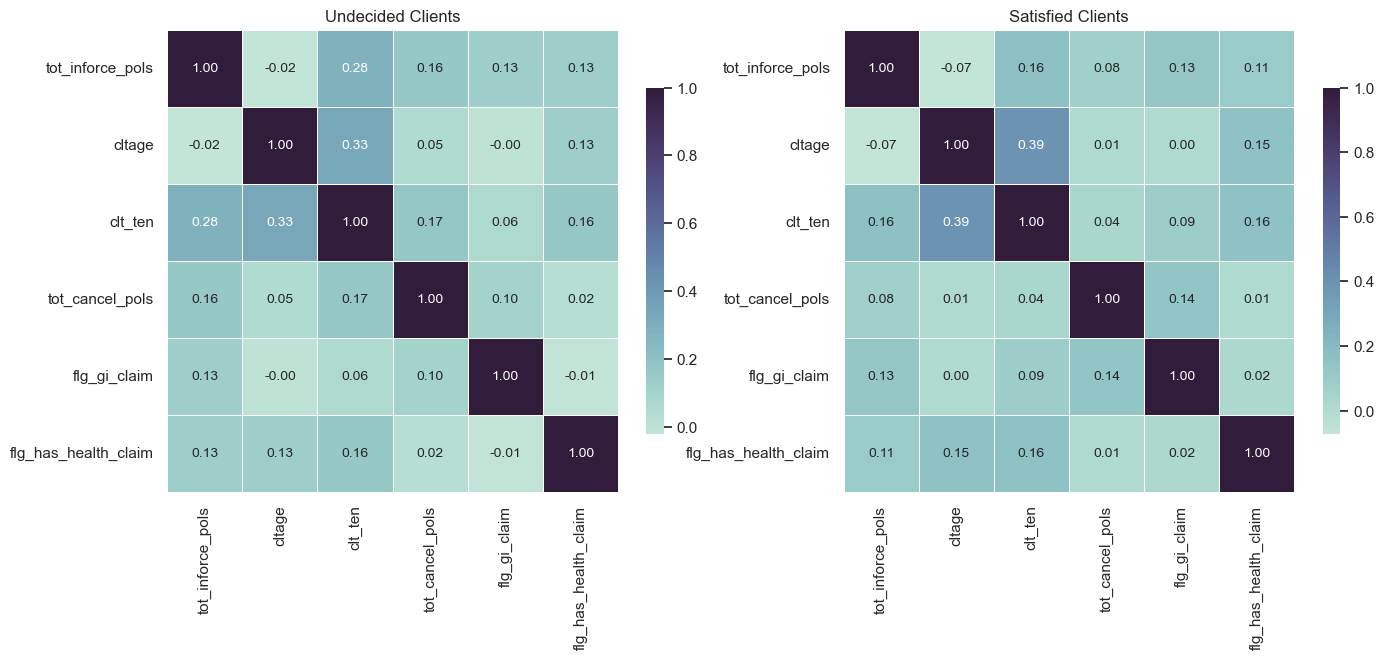

In [451]:
# Setting up the heatmap for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sat = satisfiedClients.corr()
sns.heatmap(sat, annot=True, cmap=sns.cubehelix_palette(
    start=.5, rot=-.5, as_cmap=True), ax=axes[0], fmt=".2f", linewidths=.5, annot_kws={"size": 10}, cbar_kws={"shrink": 0.75})
axes[0].set_title('Undecided Clients')
mood = moodClients.corr()
sns.heatmap(mood, annot=True, cmap=sns.cubehelix_palette(
    start=.5, rot=-.5, as_cmap=True), ax=axes[1], fmt=".2f", linewidths=.5, annot_kws={"size": 10}, cbar_kws={"shrink": 0.75})
axes[1].set_title('Satisfied Clients')

plt.show()

From these 2 heatmaps, we can easily compare what is different from the 2 groups and identify the potential variables that could have an influence on the decision to purchase a policy.

Upon analysis, we can see that client tenture has a relatively strong relationship with client age among satisfied clients, those who decided to purchase a policy and not so much in those undecided. This suggests NOTHING! :(
